In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>

In [2]:
%load_ext autoreload
%autoreload 2

# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os, math, sys
from scipy.interpolate import interp1d
import numpy as np
import json, pickle, shutil
from typing import Dict, List, Any, Optional, Literal
from matplotlib.patches import Polygon 

import concurrent.futures
import time
import numpy as np
import os
import pickle
import functools  # Importa functools
from tqdm.notebook import tqdm


from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
        
from Utils import Tex as tex
from Utils import Graphs as gph
from Utils import Signal as sgn
from Utils import Numeric as nm
from Utils import DynamicSystem as ds
from sim_worker import run_simulation
from optimization import DisturbedSaturatedPETC as DSPETC

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

cfg = {
    'style': {'color': 'black'},
    'axis': {
        'title_pad': 10,
        'x_label_fontsize': 16,
        'y_label_fontsize': 16, 
        'tick_fontsize': 16,
    },
    'legend': { 'fontsize': 16 }
}

colors_list = plt.get_cmap('tab20').colors

@register_cell_magic
def skip(line, cell):
  """
  Skip or conditionally skip the execution of a cell.

  Usage:
      %%skip              -> always skip the cell
      %%skip <condition>  -> skip only if <condition> evaluates to True

  Examples:
      %%skip
      print("This will never run")

      flag = True
      %%skip flag
      print("This will not run because flag == True")

      flag = False
      %%skip flag
      print("This will run because flag == False")
  """
  # No argument → unconditional skip
  if not line.strip():
      print("Cell skipped (unconditional).")
      return

  # Try to evaluate the condition safely
  try:
      condition = eval(line, globals())
  except Exception as e:
      print(f"Error evaluating condition '{line}': {e}")
      condition = False

  if condition:
      print(f"Cell skipped (condition: {line})")
      return
  else:
      exec(cell, globals())

LaTeX has been enabled for text rendering.


### Definição da Planta

In [3]:
experiment_config_filename = 'experiment-2'

with open(f"experiment/{experiment_config_filename}.json", encoding='utf-8') as f:
  config = json.load(f)

sim_duration = config['simulation_duration']
sim_step = config.get("simulation_step", 1e-4)
timepts = np.arange(0, sim_duration + sim_step, sim_step)

plant = ds.StateSpace(data=config["plant"], name='plant')
latex_string = plant.get_latex_equations()
print("Equações que regem a dinâmica da planta:")
display(Latex(latex_string))

Equações que regem a dinâmica da planta:


<IPython.core.display.Latex object>

### Simulação da Planta em Malha Aberta

In [5]:
sim = ds.SimulationEngine()
sim.add_system(plant)

In [6]:
%%skip

ncs.setup_clock(duration=20.0, dt=1e-4)
ncs.reset_clock()

x0 = np.array([[1.0], [-1.0]], dtype=np.float32)
ncs.get_system('plant').set_initial_state(x0)

while ncs.advance_clock():
  inputs = {'plant': {'u1': 0}}
  ncs.update_systems(inputs)

Cell skipped (unconditional).


In [7]:
%%skip

# Plotagem dos resultados
fig = plt.figure(figsize=(8, 3), layout='constrained')
axs = fig.subplot_mosaic([["x"]])

y = ncs.output_history['plant']  # shape (ny, n_steps)
t = ncs.time_history

# Calcula norma ao longo das saídas
x_norm = np.linalg.norm(y, axis=0)  # shape (n_steps,)

# Formata para plot
xnorm_f, xnorm_ul, xnorm_dp = nm.format_magnitudes(x_norm,  n_divs=5)
t_f, t_ul, t_dp = nm.format_magnitudes(t, 's', use_prefixes=True, n_divs=5)
axis_limits = {'x_min': 0., 'x_max': t_f[-1]}

gph.plot(
    axs['x'], t_f, x_norm,
    xlabel='$t$' + t_ul,
    ylabel=r'$\|x(t)\|$',
    plot_cfg={**cfg,
              'axis': {**cfg['axis'],
                       'x_digits': t_dp,
                       'y_digits': xnorm_dp},
              'limits': axis_limits,
              }
)

Cell skipped (unconditional).


### Projeto do Controlador e do ETM

In [9]:
# --- Plant data structure ---
plant_data = {
    'nx': plant.nx, 'nu': plant.nu, 'nρ': plant.n_rho, 'nw': plant.nw, 'nz': plant.nz,
    'ρ_bounds': plant.get_parameter_bounds(),
    'u_bar': plant.get_input_bounds()[0],
    'matrices_func': lambda ρi: plant.matrices_func(ρi),
}

# --- Design parameters ---
design_params = config["design_params"]["dspetc"]
design_params["δ"] = 1. / (plant.get_disturbance_l2_norm_bound())
# Flag for caching and saving results
should_save = design_params.get("save", True)

# --- Create a unique simulation identifier ---
try:
  simulation_id = ds.create_simulation_id(plant, design_params)
  print(f"Unique Simulation ID: {simulation_id}")
  results_dir = f"./results/{simulation_id}"
except (NameError, ValueError) as e:
  print(f"Error generating simulation ID: {e}")
  simulation_id = "sim_default"
  results_dir = "./results/sim_default"

# --- Cache file path ---
results_file_path = os.path.join(results_dir, "results_data.pkl")
results = None

try:
  if not should_save:
    # Execute solver without caching
    print("Save flag is False. Cache will be ignored.")
    results = DSPETC.detm_synthesis(plant_data, design_params)

  else:
    # Execute solver with caching
    print(f"Using cache file: {results_file_path}")

    if os.path.exists(results_file_path):
      # Attempt to load cache
      try:
        with open(results_file_path, 'rb') as f:
          results = pickle.load(f)
        print("Cache successfully loaded.")
      except Exception as e:
        print(f"Failed to load cache: {e}")
        results = None

    if results is None:
      # Run solver if cache does not exist or failed
      print("Running solver (fresh computation)...")
      results = DSPETC.detm_synthesis(plant_data, design_params)

      # Save results only if solver succeeds
      if results is not None:
        try:
          os.makedirs(results_dir, exist_ok=True)
          with open(results_file_path, 'wb') as f:
            pickle.dump(results, f)
          print("Results saved to cache.")
        except Exception as e:
          print(f"Failed to save results: {e}")

  # --- Process results ---
  Ξ = Ψ = K = L1 = P = γ = β = None
  Θ, λ = None, None
  optimal_value = None
  δinv = plant.get_disturbance_l2_norm_bound()

  if results is not None:
    Ξ, Ψ = results['etm']['Ξ'], results['etm']['Ψ']
    θ, λ = results['etm']['θ'], results['etm']['λ']
    K, L1, L2 = results['controller']['K'], results['controller']['L1'], results['controller']['L2']
    P, S2 = results['lyapunov']
    γ, β = results['bounds']
    optimal_value = results['optimal_value']

    # Display metrics and matrices
    print(
        f'θ = {θ:.3e}, λ = {λ:.3e}, γ = {γ:.3e}, Induced gain = {np.sqrt(1. / γ):.3e}')
    display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
    display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))
    display(Math(rf'P = {tex.mat2tex(P)}'))

    for i in nm.binary_set(plant.nρ):
      display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
      display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))

  else:
    print('Problem is infeasible or failed to load/compute results.')
    if should_save and os.path.exists(results_dir):
      shutil.rmtree(results_dir)
      print(f"Results directory removed: {results_dir}")

except Exception as e:
  print(f"Unexpected error during execution or processing: {e}")
  if should_save and os.path.exists(results_dir):
    try:
      shutil.rmtree(results_dir)
      print(f"Results directory removed after error: {results_dir}")
    except Exception as cleanup_e:
      print(f"Failed to remove results directory: {cleanup_e}")

Unique Simulation ID: sim_7b99e9c6bf16cf65b0279b5464517b8f
Using cache file: ./results/sim_7b99e9c6bf16cf65b0279b5464517b8f\results_data.pkl
Cache successfully loaded.
θ = 1.010e+00, λ = 1.000e-01, γ = 1.596e+00, Induced gain = 7.915e-01


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Unexpected error during execution or processing: 'StateSpace' object has no attribute 'nρ'
Results directory removed after error: ./results/sim_7b99e9c6bf16cf65b0279b5464517b8f


### Regiões

In [12]:
def plot_regions_comparison(plant, nm, gph, K, L1, P, δinv, γ, trajectories=None, zoom_only=False):
  """Plot 2D regions in state-space, with optional zoom-only mode and trajectories overlay.

  Parameters
  ----------
  plant : object
      Plant model containing bounds and parameters.
  nm : object
      Numerical model utilities (ellipsoid, binary sets, etc.).
  gph : object
      Graph/plot helper with polygon and legend utilities.
  K, L1 : dict
      Controller gain and auxiliary matrices.
  P : np.ndarray
      Lyapunov matrix defining the ellipsoidal regions.
  δinv : float
      Inverse delta parameter for enlarged region.
  γ : float
      Scaling factor.
  trajectories : list of np.ndarray, optional
      List of trajectories to plot, each of shape (N, 2).
  zoom_only : bool, optional
      If True, plot only the zoomed region and overlay trajectories.
  """

  num_points = 20
  B2 = nm.binary_set(plant.n_rho)
  u_bar = plant.get_input_bounds()
  X0 = nm.ellipsoid_boundary_points(P, 1, num_points)
  D0 = nm.get_ellipsoid_boundary(P, 1)
  Dx = nm.get_ellipsoid_boundary(P, 1 + δinv / γ)

  if len(B2) != 2:
    print(f"Warning: Expected len(B2) == 2 but got {len(B2)}.")

  b1, b2 = B2[:2]

  def parallelogram_vertices(H1, H2):
    return gph.get_parallelogram2D_vertices(H1, H2, u_bar)[0]

  du_poly = parallelogram_vertices(K[b1] - L1[b1], K[b2] - L1[b2])
  du_tilde_poly = parallelogram_vertices(K[b1], K[b2])

  def compute_limits(x_data, y_data, padding_ratio=0.1):
    min_x, max_x = np.min(x_data), np.max(x_data)
    min_y, max_y = np.min(y_data), np.max(y_data)
    pad_x = (max_x - min_x) * padding_ratio
    pad_y = (max_y - min_y) * padding_ratio
    return (min_x - pad_x, max_x + pad_x), (min_y - pad_y, max_y + pad_y)

  all_x_ax1 = np.concatenate(
      [X0[0], D0['x1_vals'], Dx['x1_vals'], du_poly[:, 0]])
  all_y_ax1 = np.concatenate(
      [X0[1], D0['x2_vals'], Dx['x2_vals'], du_poly[:, 1]])
  x1_range_ax1, x2_range_ax1 = compute_limits(all_x_ax1, all_y_ax1)

  all_x_ax2 = np.concatenate([D0['x1_vals'], Dx['x1_vals']])
  all_y_ax2 = np.concatenate([D0['x2_vals'], Dx['x2_vals']])
  x1_range_ax2, x2_range_ax2 = compute_limits(all_x_ax2, all_y_ax2)

  def draw_region(ax, zoom=False):
    ax.add_patch(Polygon(du_tilde_poly, closed=True,
                         edgecolor='#d0d0d0', facecolor='white',
                         linestyle=':', linewidth=2.0, zorder=1))
    ax.add_patch(Polygon(du_poly, closed=True,
                         edgecolor='#084475', fill=False,
                         linewidth=1.5, zorder=2))

    ax.plot(X0[0], X0[1], '*', c='black', markersize=12, zorder=3)
    ax.plot(D0['x1_vals'], D0['x2_vals'], 'k-', zorder=3)
    ax.plot(Dx['x1_vals'], Dx['x2_vals'], 'k--', zorder=3)

    # Optional trajectories
    if trajectories is not None:
      for traj in trajectories:
        ax.plot(traj[:, 0], traj[:, 1], '-',
                linewidth=1.8, alpha=0.8, zorder=4)

    ax.set_xlabel("$x_1$", fontsize=20)
    ax.set_ylabel("$x_2$", fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_facecolor('#f5f5f5')
    ax.grid(True, zorder=0)

    if zoom:
      ax.set_xlim(x1_range_ax2)
      ax.set_ylim(x2_range_ax2)
    else:
      ax.set_xlim(x1_range_ax1)
      ax.set_ylim(x2_range_ax1)

    elements = [
        ('line', {'color': '#084475', 'linestyle': '-', 'linewidth': 2.0}),
        ('line', {'color': '#d0d0d0', 'linestyle': ':', 'linewidth': 2.0}),
        ('line', {'color': 'black', 'linestyle': '--', 'linewidth': 2.}),
        ('line', {'color': 'black', 'linestyle': '-', 'linewidth': 2.}),
        ('marker', {'marker': '*', 'color': 'black', 'markersize': 10})
    ]
    labels = [r'$\mathscr{D}_u$', r'$\tilde{\mathscr{D}}_u$',
              r'$\mathscr{D}_x$', r'$\mathscr{D}_0$', '$x_0$']
    gph.create_custom_legend(ax, elements, labels)

  # --- Rendering ---
  if zoom_only:
    fig, ax = plt.subplots(figsize=(6., 6.))
    draw_region(ax, zoom=True)
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12., 6.))
    draw_region(ax1, zoom=False)
    draw_region(ax2, zoom=True)

  plt.tight_layout()
  return fig

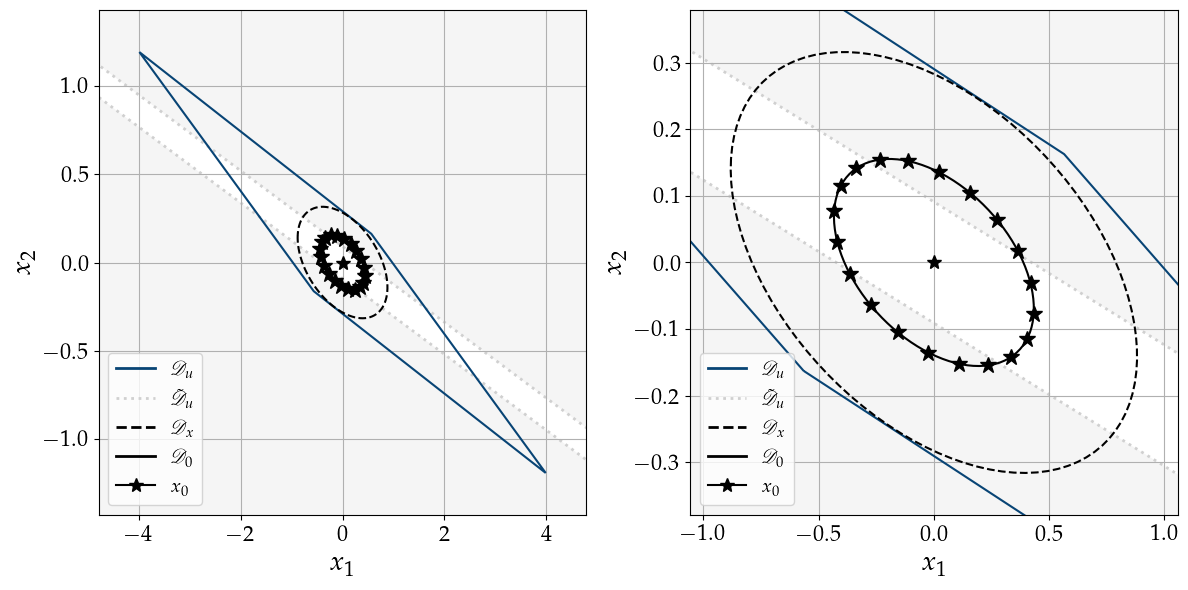

In [13]:
%%skip plant.nx != 2

plot_regions_comparison(plant, nm, gph, K, L1, P, δinv, γ)

### Simulação do Sistema em Malha Fechada

In [14]:
FORCE_RECALCULATE = True
SAVE_TO_CACHE = False
NUM_POINTS = 2
MAX_WORKERS = 15
indices_to_run = list(range(NUM_POINTS))
all_results = []

try:
  if 'config' not in globals() or 'results' not in globals():
    raise NameError(
        "Variables 'config' or 'results' not found. Please execute cells [3] and [7] first."
    )

  simulation_id = ds.create_simulation_id(
      plant, config["design_params"]["dspetc"]
  )
  results_dir = f"./Results/{simulation_id}"
  trajectories_cache_file = os.path.join(
      results_dir, "trajectories_cache.pkl")
  abs_trajectories_path = os.path.abspath(trajectories_cache_file)

  if os.path.exists(abs_trajectories_path) and not FORCE_RECALCULATE:
    print(
        f"Loading {NUM_POINTS} trajectories from cache: {abs_trajectories_path}")
    with tqdm(total=1, desc="Reading cache") as pbar:
      with open(abs_trajectories_path, 'rb') as f:
        all_results = pickle.load(f)
      pbar.update(1)
    print("Cache successfully loaded.")

  else:
    print(
        f"Starting {NUM_POINTS} simulations... "
        f"(force_recalculate_trajectories={FORCE_RECALCULATE})"
    )
    start_time = time.time()

    P = results['lyapunov'][0]
    X0_matrix = ds.ellipsoid_boundary_points(P, 1, NUM_POINTS)

    x0_inputs = [
        X0_matrix[:, i].reshape(-1, 1).astype(np.float32)
        for i in range(NUM_POINTS)
    ]

    run_sim_partial = functools.partial(
        run_simulation, config=config, results=results)

    if __name__ == "__main__":
      with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        print(
            f"Running simulations (max {MAX_WORKERS} workers in parallel)...")

        results_iter = executor.map(run_sim_partial, x0_inputs)

        for idx, result in tqdm(enumerate(results_iter), total=NUM_POINTS, desc="Simulations"):
          try:
            if isinstance(result[0], str) and "Erro" in result[0]:
              print(
                  f"\nSimulation (idx {idx}) failed: {result[0]}")
            else:
              all_results.append((idx,) + result)
          except Exception as e:
            print(f"\nException raised during pool execution: {e}")

    end_time = time.time()
    print("---")
    print(
        f"Parallel processing completed in {end_time - start_time:.2f} seconds.")

    if len(all_results) == NUM_POINTS:
      if SAVE_TO_CACHE:
        print(
            f"Saving {NUM_POINTS} trajectories to cache: {abs_trajectories_path}")
        all_results.sort(key=lambda x: x[0])
        os.makedirs(results_dir, exist_ok=True)
        with tqdm(total=1, desc="Saving cache") as pbar:
          with open(abs_trajectories_path, 'wb') as f:
            pickle.dump(all_results, f)
          pbar.update(1)
      else:
        print("Cache saving skipped (SAVE_TO_CACHE=False).")
    else:
      print(
          f"ERROR: Some simulations failed ({len(all_results)}/{NUM_POINTS}). "
          "Cache will not be saved."
      )

except Exception as e:
  print(f"An error occurred while setting up cache or process pool: {e}")
  import traceback
  traceback.print_exc()

all_results.sort(key=lambda x: x[0])
print(f"\nTotal number of ready results: {len(all_results)}")

Starting 2 simulations... (force_recalculate_trajectories=True)
Running simulations (max 15 workers in parallel)...


Simulations:   0%|          | 0/2 [00:00<?, ?it/s]

---
Parallel processing completed in 120.78 seconds.
Cache saving skipped (SAVE_TO_CACHE=False).

Total number of ready results: 2


In [18]:
# ============================================================
# 1. CONFIGURATION
# ============================================================
index_to_plot = 0


class MockNCS:
  """Mock object to emulate an NCS instance with time and output histories."""

  def __init__(self, y_data, t_data):
    self.output_history = {'plant': y_data}
    self.time_history = t_data


# ============================================================
# 2. DATA VALIDATION AND SELECTION
# ============================================================
if 'all_results' in globals() and len(all_results) > 0:
  if 0 <= index_to_plot < len(all_results):
    print(f"Preparing data for plotting (index = {index_to_plot})...")
    # 1. Find the corresponding result (may not be ordered)
    selected_result = next(
        (res for res in all_results if res[0] == index_to_plot), None
    )
    if selected_result is not None:
      # 2. Unpack the selected result tuple
      idx, y_data, t_data, control_signal, η_data, event_times = selected_result
      # 3. Create a mock NCS object with the simulation data
      sim = MockNCS(y_data, t_data)
      print(
          "Variables 'ncs', 'control_signal', and 'event_times' have been updated.")
    else:
      print(f"Error: No result found for index = {index_to_plot}.")
  else:
    print(
        f"Error: 'index_to_plot' must be between 0 and {len(all_results) - 1}.")
else:
  print("Error: 'all_results' not found. Please run the parallel simulation cell first.")

Preparing data for plotting (index = 0)...
Variables 'ncs', 'control_signal', and 'event_times' have been updated.


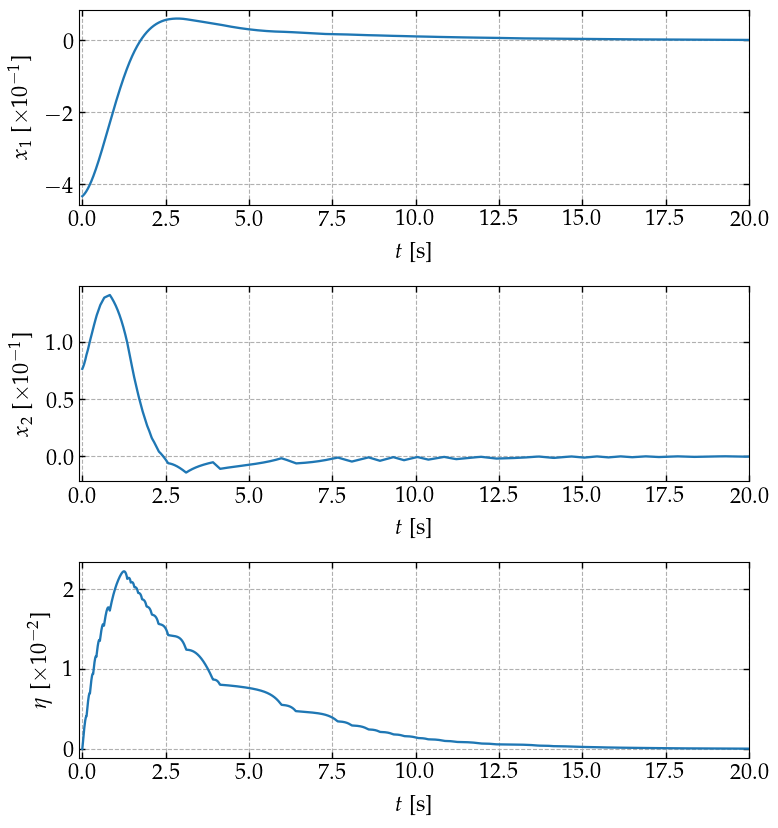

In [19]:
# ============================================================
# 1. CONFIGURATION
# ============================================================
stacked_layout = True  # True → one subplot per state; False → all together

# Adjust figure height dynamically
base_height = 6
fig_height = base_height if not stacked_layout else base_height + \
    2.5 * (plant.nx - 1)

# Create base figure and mosaic
mosaic = [['x'], ['η']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, fig_height))

y = sim.output_history['plant']
t = sim.time_history

fy = nm.format_magnitudes(y.flatten(), '', False, return_order=True)
scaled_y, y_label, y_order = fy
prev_fmt = (None, (scaled_y, y_label, y_order))


# ============================================================
# 2. PLOT OF STATE TRAJECTORIES
# ============================================================
if stacked_layout:
  from matplotlib.gridspec import GridSpec

  # Remove the placeholder subplot and rebuild the grid
  axs['x'].remove()
  axs['η'].remove()

  # Build new grid for all x_i and η, sharing the x-axis
  total_rows = plant.nx + 1
  gs = GridSpec(total_rows, 1, figure=fig, height_ratios=[1] * total_rows)

  # Create axes for x_i
  axs_x = []
  for i in range(plant.nx):
    axs_x.append(fig.add_subplot(gs[i, 0], sharex=axs_x[0] if i > 0 else None))

  # Axis for η(t)
  ax_eta = fig.add_subplot(gs[-1, 0], sharex=axs_x[0])

  # Plot x_i(t)
  for i, ax in enumerate(axs_x):
    _ = gph.plot(
        ax, t, y[i],
        xlabel='$t$',
        x_unit='s',
        x_use_prefixes=True,
        ylabel=fr'$x_{i+1}$',
        cfg={**cfg, 'style': {'color': colors_list[0]}},
        x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
    )

  axs['η'] = ax_eta  # store η axis back in the dict for consistency

else:
  # Combined subplot for all x_i
  for i in range(plant.nx):
    current_color = colors_list[i]
    _ = gph.plot(
        axs['x'], t, y[i],
        xlabel='$t$', x_unit='s', x_use_prefixes=True,
        ylabel=r'$x(t)$',
        label=fr'$x_{i}$',
        prev_format=prev_fmt,
        cfg={**cfg, 'style': {'color': current_color}},
        x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
    )


# ============================================================
# 3. PLOT OF η(t)
# ============================================================
_ = gph.plot(
    axs['η'], t, η_data[0],
    xlabel='$t$', x_unit='s', x_use_prefixes=True,
    ylabel=r'$\eta$',
    cfg={**cfg, 'style': {'color': colors_list[0]}},
    x_pad=(0.005, 0.0), y_pad=(0.05, 0.05)
)

plt.tight_layout(pad=1.5)
plt.show()

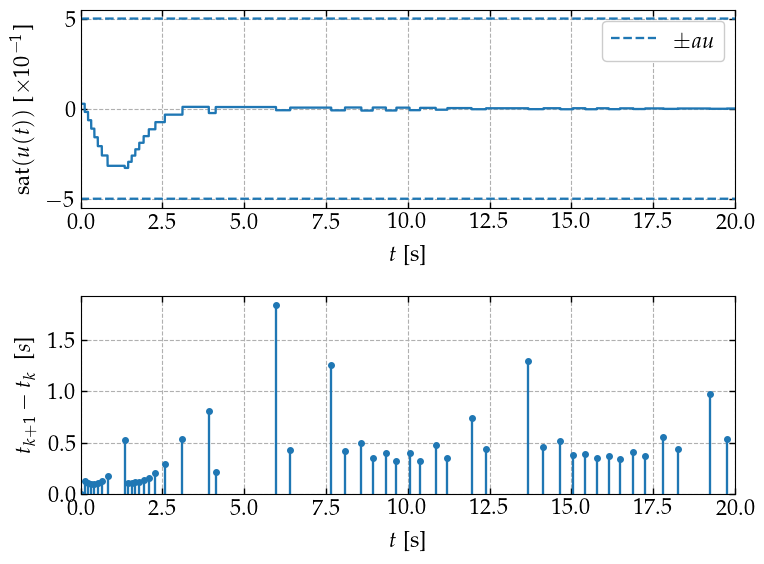

In [22]:
importlib.reload(gph)

mosaic = [['control'], ['iet']]
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 6))

inter_event_time = DSPETC.get_iet(event_times)
u_bar = plant.get_input_bounds()

for i in range(plant.nu):
  y_multi = [control_signal[i] for i in range(plant.nu)] + [
      [u_bar[i]] * len(t),
      [-u_bar[i]] * len(t)
  ]

  gph.plot(
      axs['control'], t, y_multi, xlabel='$t$', x_unit='s', x_use_prefixes=True,
      ylabel=r'sat$(u(t))$', label=['', '', r'$\pm au$'], y_pad=(0.05, 0.05),
      cfg={**cfg, 'style': {'color': colors_list[0],
                            "linestyle": ["-", "--", "--"], }},)


gph.stem(
    axs['iet'], event_times, inter_event_time,
    reuse_previous=False, y_pad=(0.0, 0.05), x_use_prefixes=True,
    xlabel='$t$', x_unit='s', x_range=(0.0, t[-1]),
    ylabel='$t_{k+1} - t_k\\;$ [$s$]',
    cfg={**cfg, 'limits': {'x_min': 0,
                           'x_max': t[-1]}, 'style': {'color': colors_list[0]}})

plt.tight_layout(pad=2.)

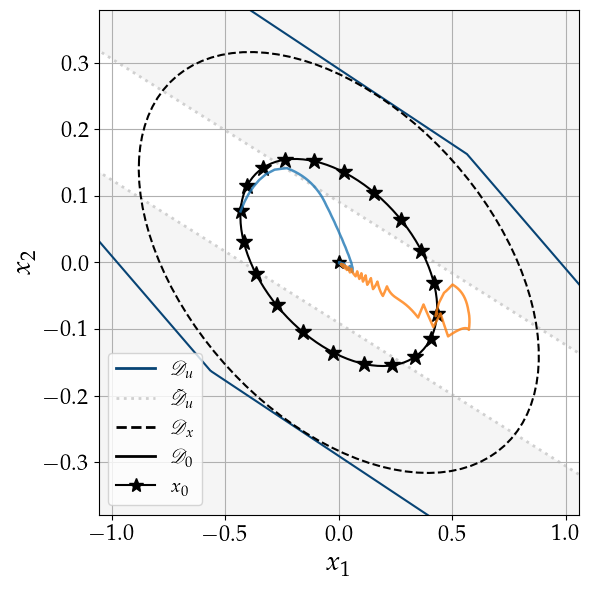

In [23]:
%%skip plant.nx != 2

traj_list = [x.T for (_, x, _, _, _, _) in all_results]
plot_regions_comparison(plant, nm, gph, K, L1, P, δinv, γ,
                        zoom_only=True, trajectories=traj_list)